In [53]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

## Getting the data

In [44]:
# Define the dataset path
dataset_path = "images"

# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.lower().endswith(('.jpg', '.jpeg'))]

        # Collect unique labels
        self.classes = set()
        for file in self.image_files:
            is_cat = file[0].isupper()
            breed = file.split("_")[0].lower() if not is_cat else file.split("_")[0]
            self.classes.add(breed)

        # Convert set to a sorted list for consistent order
        self.classes = sorted(list(self.classes))

        # Create a dictionary to map class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # determine if it's a cat or dog based on the first letter
        is_cat = image_file[0].isupper()
        breed = image_file.split("_")[0].lower() if not is_cat else image_file.split("_")[0]

        # Map class name to index
        label = self.class_to_idx[breed]

        return image, label

In [62]:
# Create an instance of the custom dataset
dataset = CustomDataset(root_dir=dataset_path, transform=transform)

# Use random_split to create training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Save the class_to_idx mapping for future reference
torch.save(dataset.class_to_idx, 'class_to_idx.pth')

# Save the datasets and dataloaders for future use
torch.save(train_dataset, 'train_dataset.pth')
torch.save(val_dataset, 'val_dataset.pth')
torch.save(train_loader, 'train_loader.pth')
torch.save(val_loader, 'val_loader.pth')


1
train data set classes ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British', 'Egyptian', 'Maine', 'Persian', 'Ragdoll', 'Russian', 'Siamese', 'Sphynx', 'american', 'basset', 'beagle', 'boxer', 'chihuahua', 'english', 'german', 'great', 'havanese', 'japanese', 'keeshond', 'leonberger', 'miniature', 'newfoundland', 'pomeranian', 'pug', 'saint', 'samoyed', 'scottish', 'shiba', 'staffordshire', 'wheaten', 'yorkshire']


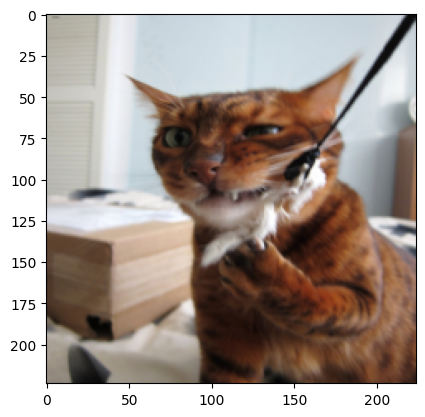

In [46]:
train_dataset = torch.load('./preprocessed-data/train_dataset.pth')
plt.imshow(train_dataset[1][0].permute(1, 2, 0))
print(train_dataset[1][1])

print("train data set classes",(train_dataset.dataset.classes))


# now extracting features from Resnet-18

In [5]:
# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the saved datasets
train_dataset = torch.load('train_dataset.pth')
val_dataset = torch.load('val_dataset.pth')

# Create DataLoader for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

In [6]:
# Remove the fully connected layers from the model
resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

# Define the SVM model
class ResNet18Features(nn.Module):
    def __init__(self):
        super(ResNet18Features, self).__init__()
        self.resnet18 = resnet18

    def forward(self, x):
        return self.resnet18(x)

# Create instances of ResNet18Features
model_avgpool = ResNet18Features()
model_block1 = ResNet18Features()
model_block3 = ResNet18Features()


In [16]:
# Extract features from average pooling, block 1, and block 3
def extract_features(model, loader):
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            outputs = model(images)
            features.append(outputs.squeeze().cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

In [8]:
# Extract features from average pooling
avgpool_features_train, avgpool_labels_train = extract_features(model_avgpool, train_loader)
avgpool_features_val, avgpool_labels_val = extract_features(model_avgpool, val_loader)

# Extract features from block 1
block1_features_train, block1_labels_train = extract_features(model_block1, train_loader)
block1_features_val, block1_labels_val = extract_features(model_block1, val_loader)

# Extract features from block 3
block3_features_train, block3_labels_train = extract_features(model_block3, train_loader)
block3_features_val, block3_labels_val = extract_features(model_block3, val_loader)

In [11]:
# Save the extracted features and labels to .npy files
np.save('res-net/avgpool_features_train.npy', avgpool_features_train)
np.save('res-net/avgpool_labels_train.npy', avgpool_labels_train)
np.save('res-net/avgpool_features_val.npy', avgpool_features_val)
np.save('res-net/avgpool_labels_val.npy', avgpool_labels_val)

np.save('res-net/block1_features_train.npy', block1_features_train)
np.save('res-net/block1_labels_train.npy', block1_labels_train)
np.save('res-net/block1_features_val.npy', block1_features_val)
np.save('res-net/block1_labels_val.npy', block1_labels_val)

np.save('res-net/block3_features_train.npy', block3_features_train)
np.save('res-net/block3_labels_train.npy', block3_labels_train)
np.save('res-net/block3_features_val.npy', block3_features_val)
np.save('res-net/block3_labels_val.npy', block3_labels_val)

In [14]:
# Load the extracted features and labels from .npy files
avgpool_features_train = np.load('res-net/avgpool_features_train.npy')
avgpool_labels_train = np.load('res-net/avgpool_labels_train.npy')
avgpool_features_val = np.load('res-net/avgpool_features_val.npy')
avgpool_labels_val = np.load('res-net/avgpool_labels_val.npy')

block1_features_train = np.load('res-net/block1_features_train.npy')
block1_labels_train = np.load('res-net/block1_labels_train.npy')
block1_features_val = np.load('res-net/block1_features_val.npy')
block1_labels_val = np.load('res-net/block1_labels_val.npy')

block3_features_train = np.load('res-net/block3_features_train.npy')
block3_labels_train = np.load('res-net/block3_labels_train.npy')
block3_features_val = np.load('res-net/block3_features_val.npy')
block3_labels_val = np.load('res-net/block3_labels_val.npy')

In [16]:
# Concatenate features from different blocks
train_features = np.concatenate([avgpool_features_train, block1_features_train, block3_features_train], axis=1)
val_features = np.concatenate([avgpool_features_val, block1_features_val, block3_features_val], axis=1)

# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

In [19]:
print(train_features_flat.shape, val_features_flat.shape)

(5912, 75264) (1478, 75264)


In [ ]:
n_components = 3000  # You can adjust this value based on your requirements

# Apply PCA to training features
pca = PCA(n_components=n_components)
train_features_pca = pca.fit_transform(train_features_flat)

# Apply PCA to validation features
val_features_pca = pca.transform(val_features_flat)

In [36]:
print(train_features_pca.shape, val_features_pca.shape)

(5912, 3000) (1478, 3000)


In [37]:
# Train an SVM with RBF kernel
svm_model = SVC(kernel='rbf', max_iter=2000)
svm_model.fit(train_features_pca, avgpool_labels_train) 

# Evaluate the model on the validation set
predictions = svm_model.predict(val_features_pca)
accuracy = accuracy_score(avgpool_labels_val, predictions)
precision = precision_score(avgpool_labels_val, predictions, average='macro')
recall = recall_score(avgpool_labels_val, predictions, average='macro')
f1 = f1_score(avgpool_labels_val, predictions, average='macro')
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')


Accuracy: 0.7835, Precision: 0.8209, Recall: 0.7784, F1: 0.7865


In [41]:
# save the model
joblib.dump(svm_model, 'svm_model_resnet.pkl')

['svm_model_resnet.pkl']

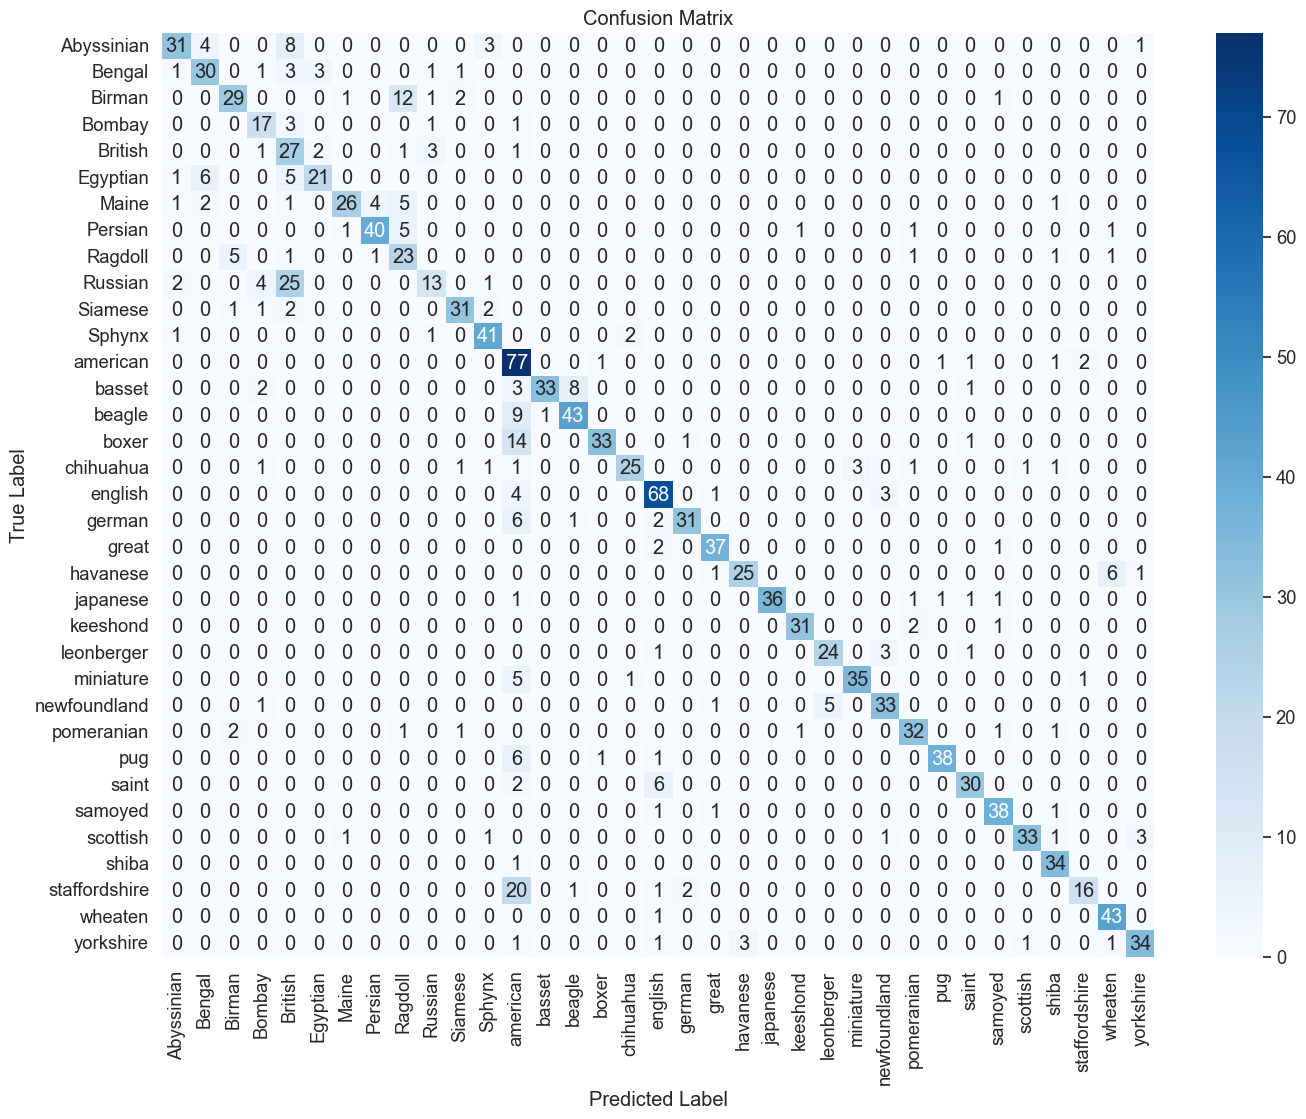

In [48]:
# plot the confusion matrix
true_labels = avgpool_labels_val
pred_labels = predictions

cm = confusion_matrix(avgpool_labels_val, predictions)

classes = train_dataset.dataset.classes

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Macro-average ROC AUC: 0.99


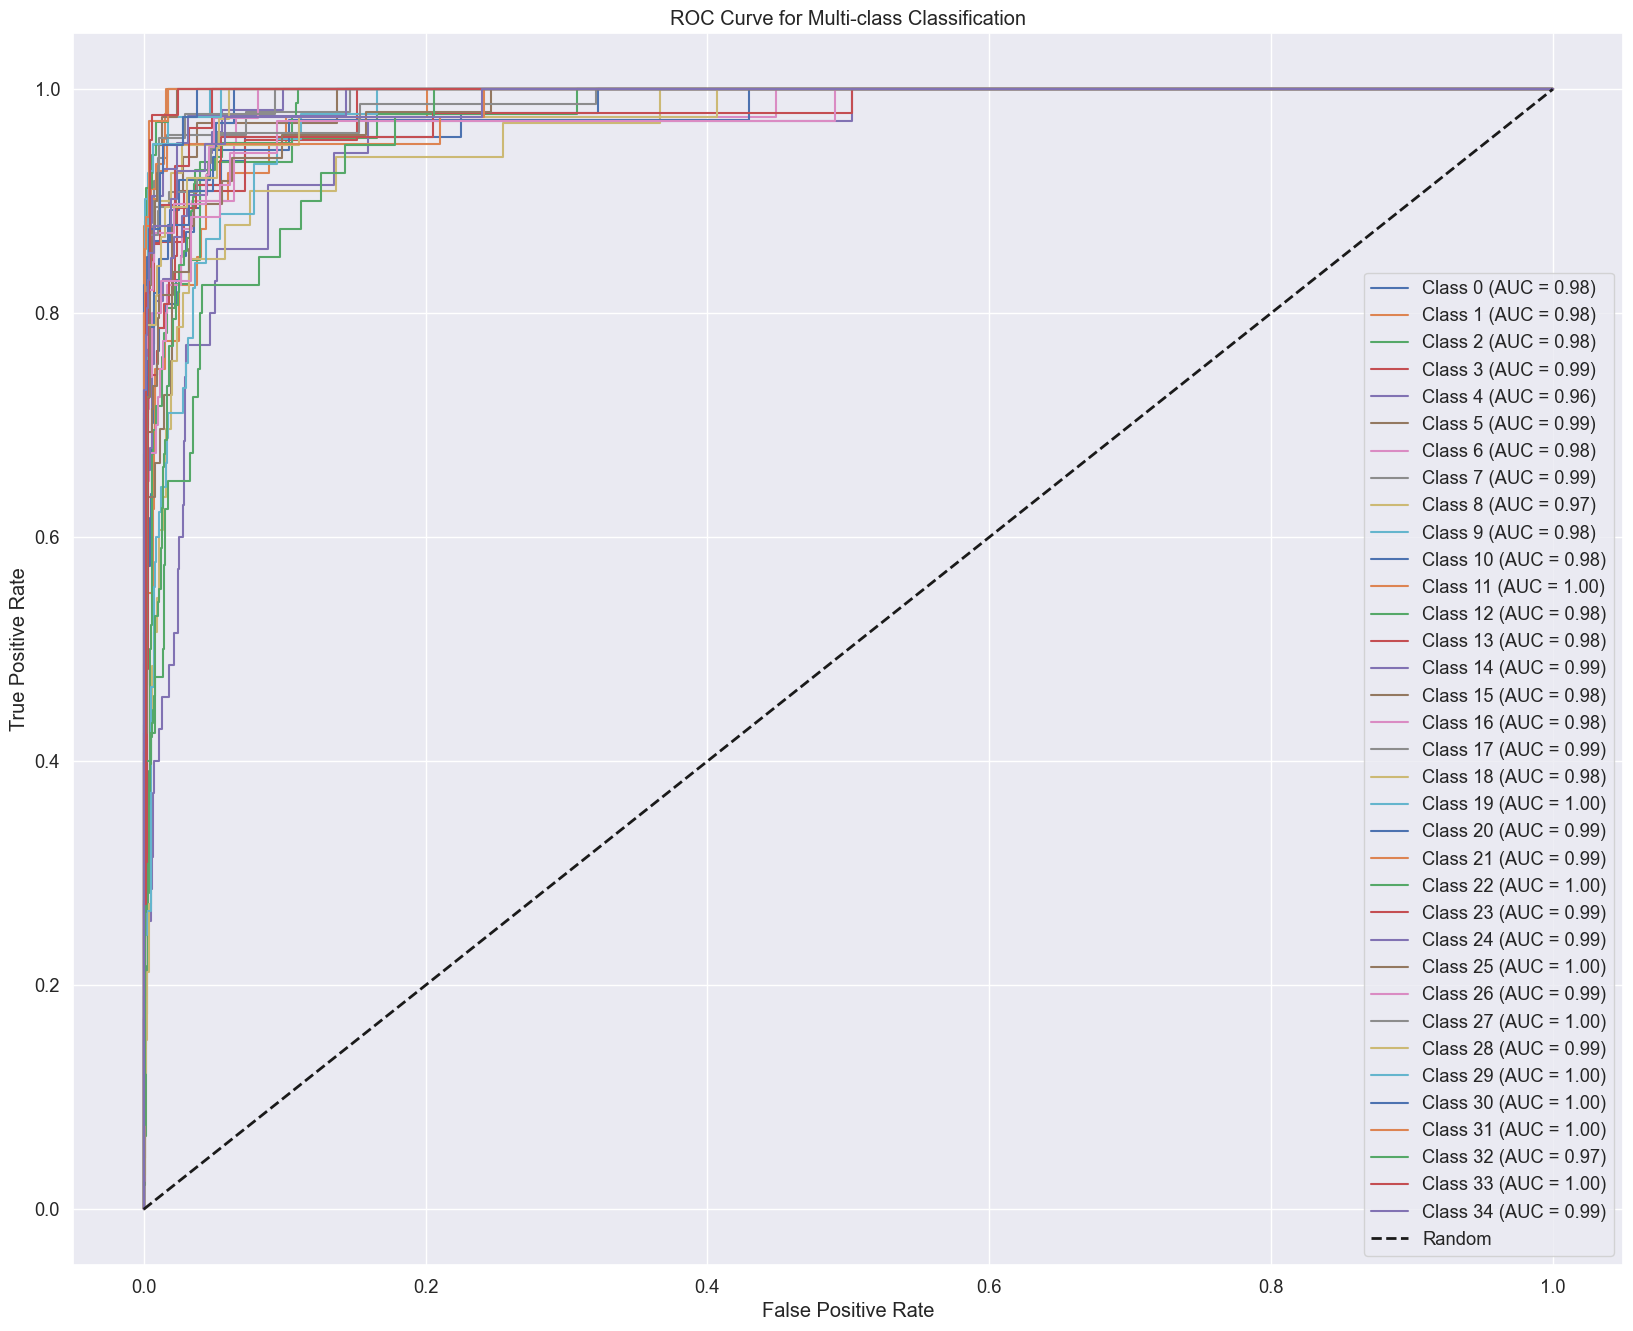

In [55]:
true_labels = avgpool_labels_val
predicted_scores = svm_model.decision_function(val_features_pca)

n_classes = len(train_dataset.dataset.classes)

true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
roc_auc_macro = roc_auc_score(true_labels_bin, predicted_scores, average='macro')
print(f'Macro-average ROC AUC: {roc_auc_macro:.2f}')

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(20, 16))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [13]:
# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the saved datasets
train_dataset = torch.load('train_dataset.pth')
val_dataset = torch.load('val_dataset.pth')

# Create DataLoader for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Load pre-trained GoogLeNet (Inception) model
googlenet = models.googlenet(pretrained=True)

# Remove the fully connected layers from the model
googlenet = nn.Sequential(*list(googlenet.children())[:-1])

# Define the SVM model
class GoogLeNetFeatures(nn.Module):
    def __init__(self):
        super(GoogLeNetFeatures, self).__init__()
        self.googlenet = googlenet

    def forward(self, x):
        return self.googlenet(x)

# Create instances of GoogLeNetFeatures
model_inception3b = GoogLeNetFeatures()
model_inception4e = GoogLeNetFeatures()
model_avgpool = GoogLeNetFeatures()



Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\alast/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [17]:

# Extract features from Inception (3b)
inception3b_features_train, inception3b_labels_train = extract_features(model_inception3b, train_loader)
inception3b_features_val, inception3b_labels_val = extract_features(model_inception3b, val_loader)

# Extract features from Inception (4e)
inception4e_features_train, inception4e_labels_train = extract_features(model_inception4e, train_loader)
inception4e_features_val, inception4e_labels_val = extract_features(model_inception4e, val_loader)

# Extract features from AvgPool
avgpool_features_train, avgpool_labels_train = extract_features(model_avgpool, train_loader)
avgpool_features_val, avgpool_labels_val = extract_features(model_avgpool, val_loader)

c:\Python310\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [18]:
# Save the extracted features and labels to .npy files
np.save('./inception/inception3b_features_train.npy', inception3b_features_train)
np.save('./inception/inception3b_labels_train.npy', inception3b_labels_train)
np.save('./inception/inception3b_features_val.npy', inception3b_features_val)
np.save('./inception/inception3b_labels_val.npy', inception3b_labels_val)

np.save('./inception/inception4e_features_train.npy', inception4e_features_train)
np.save('./inception/inception4e_labels_train.npy', inception4e_labels_train)
np.save('./inception/inception4e_features_val.npy', inception4e_features_val)
np.save('./inception/inception4e_labels_val.npy', inception4e_labels_val)

np.save('./inception/inception_avgpool_features_train.npy', avgpool_features_train)
np.save('./inception/inception_avgpool_labels_train.npy', avgpool_labels_train)
np.save('./inception/inception_avgpool_features_val.npy', avgpool_features_val)
np.save('./inception/inception_avgpool_labels_val.npy', avgpool_labels_val)

In [58]:
# Load the extracted features and labels from .npy files
inception3b_features_train = np.load('./inception/inception3b_features_train.npy')
inception3b_labels_train = np.load('./inception/inception3b_labels_train.npy')
inception3b_features_val = np.load('./inception/inception3b_features_val.npy')
inception3b_labels_val = np.load('./inception/inception3b_labels_val.npy')

inception4e_features_train = np.load('./inception/inception4e_features_train.npy')
inception4e_labels_train = np.load('./inception/inception4e_labels_train.npy')
inception4e_features_val = np.load('./inception/inception4e_features_val.npy')
inception4e_labels_val = np.load('./inception/inception4e_labels_val.npy')

avgpool_features_train = np.load('./inception/inception_avgpool_features_train.npy')
avgpool_labels_train = np.load('./inception/inception_avgpool_labels_train.npy')
avgpool_features_val = np.load('./inception/inception_avgpool_features_val.npy')
avgpool_labels_val = np.load('./inception/inception_avgpool_labels_val.npy')

In [59]:

# Concatenate features from different Inception blocks
train_features = np.concatenate([inception3b_features_train, inception4e_features_train, avgpool_features_train], axis=1)
val_features = np.concatenate([inception3b_features_val, inception4e_features_val, avgpool_features_val], axis=1)

# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)


# Train an SVM with RBF kernel
svm_model = SVC(kernel='rbf', max_iter=2000)
svm_model.fit(train_features, inception3b_labels_train)  # You can choose any set of labels, e.g., inception3b_labels_train or inception4e_labels_train

# Evaluate the model on the validation set
predictions = svm_model.predict(val_features)
accuracy = accuracy_score(inception3b_labels_val, predictions)  # You can choose any set of labels, e.g., inception3b_labels_val or inception4e_labels_val
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.881596752368065


In [24]:
loaded_svm_model = joblib.dump(svm_model, './inception/svm_model_inception_features.joblib')

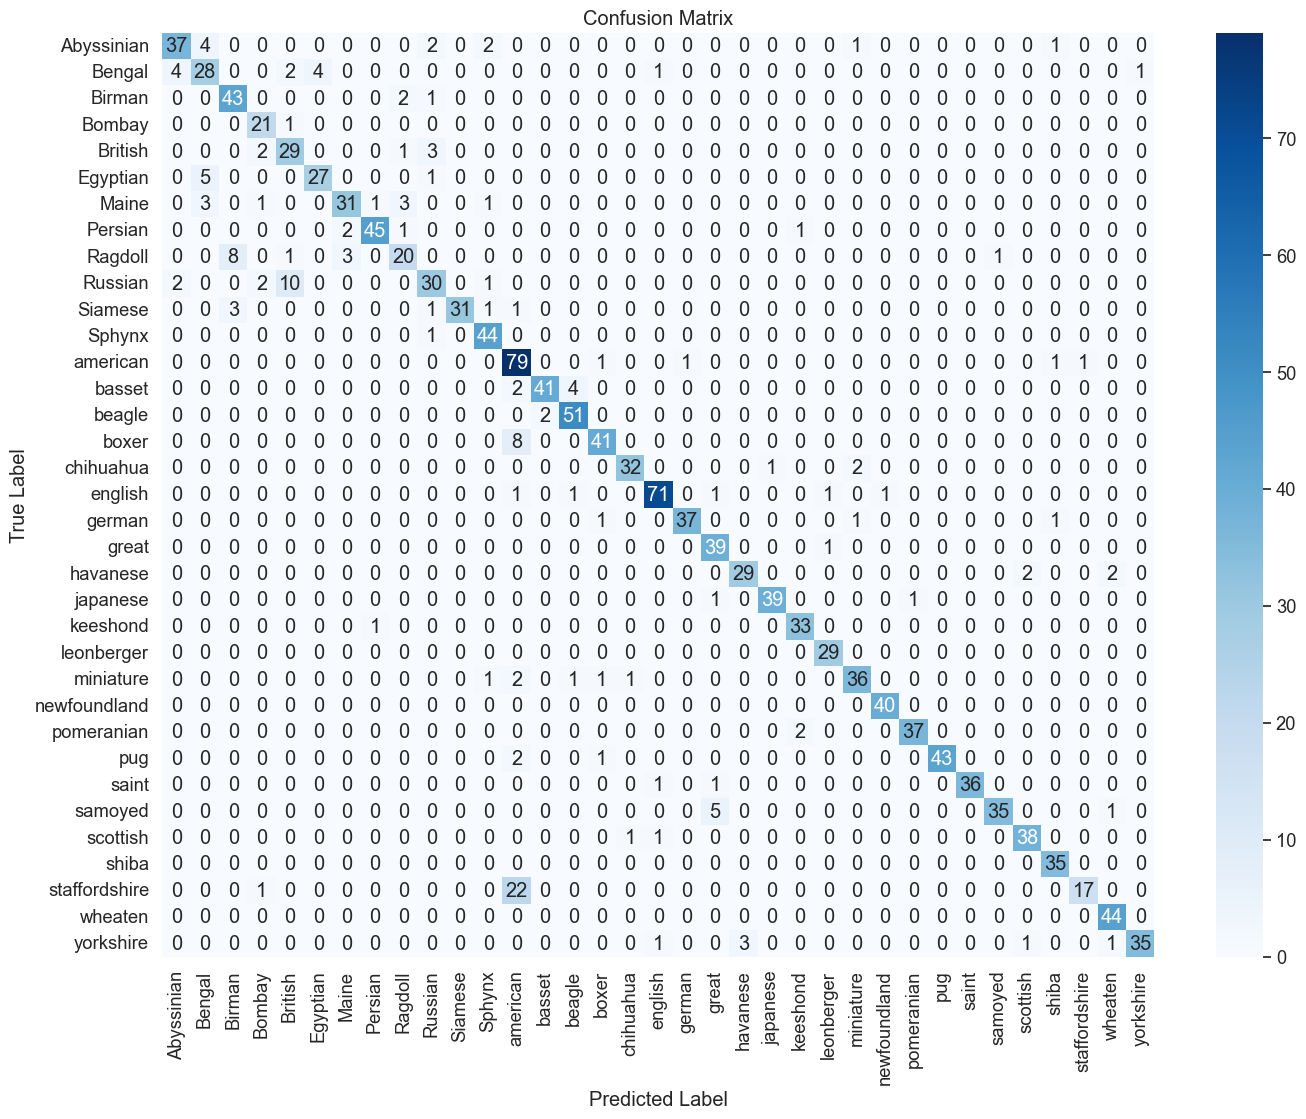

In [60]:
# plot the confusion matrix
true_labels = inception3b_labels_val
pred_labels = predictions

cm = confusion_matrix(inception3b_labels_val, predictions)

classes = train_dataset.dataset.classes

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Macro-average ROC AUC: 1.00


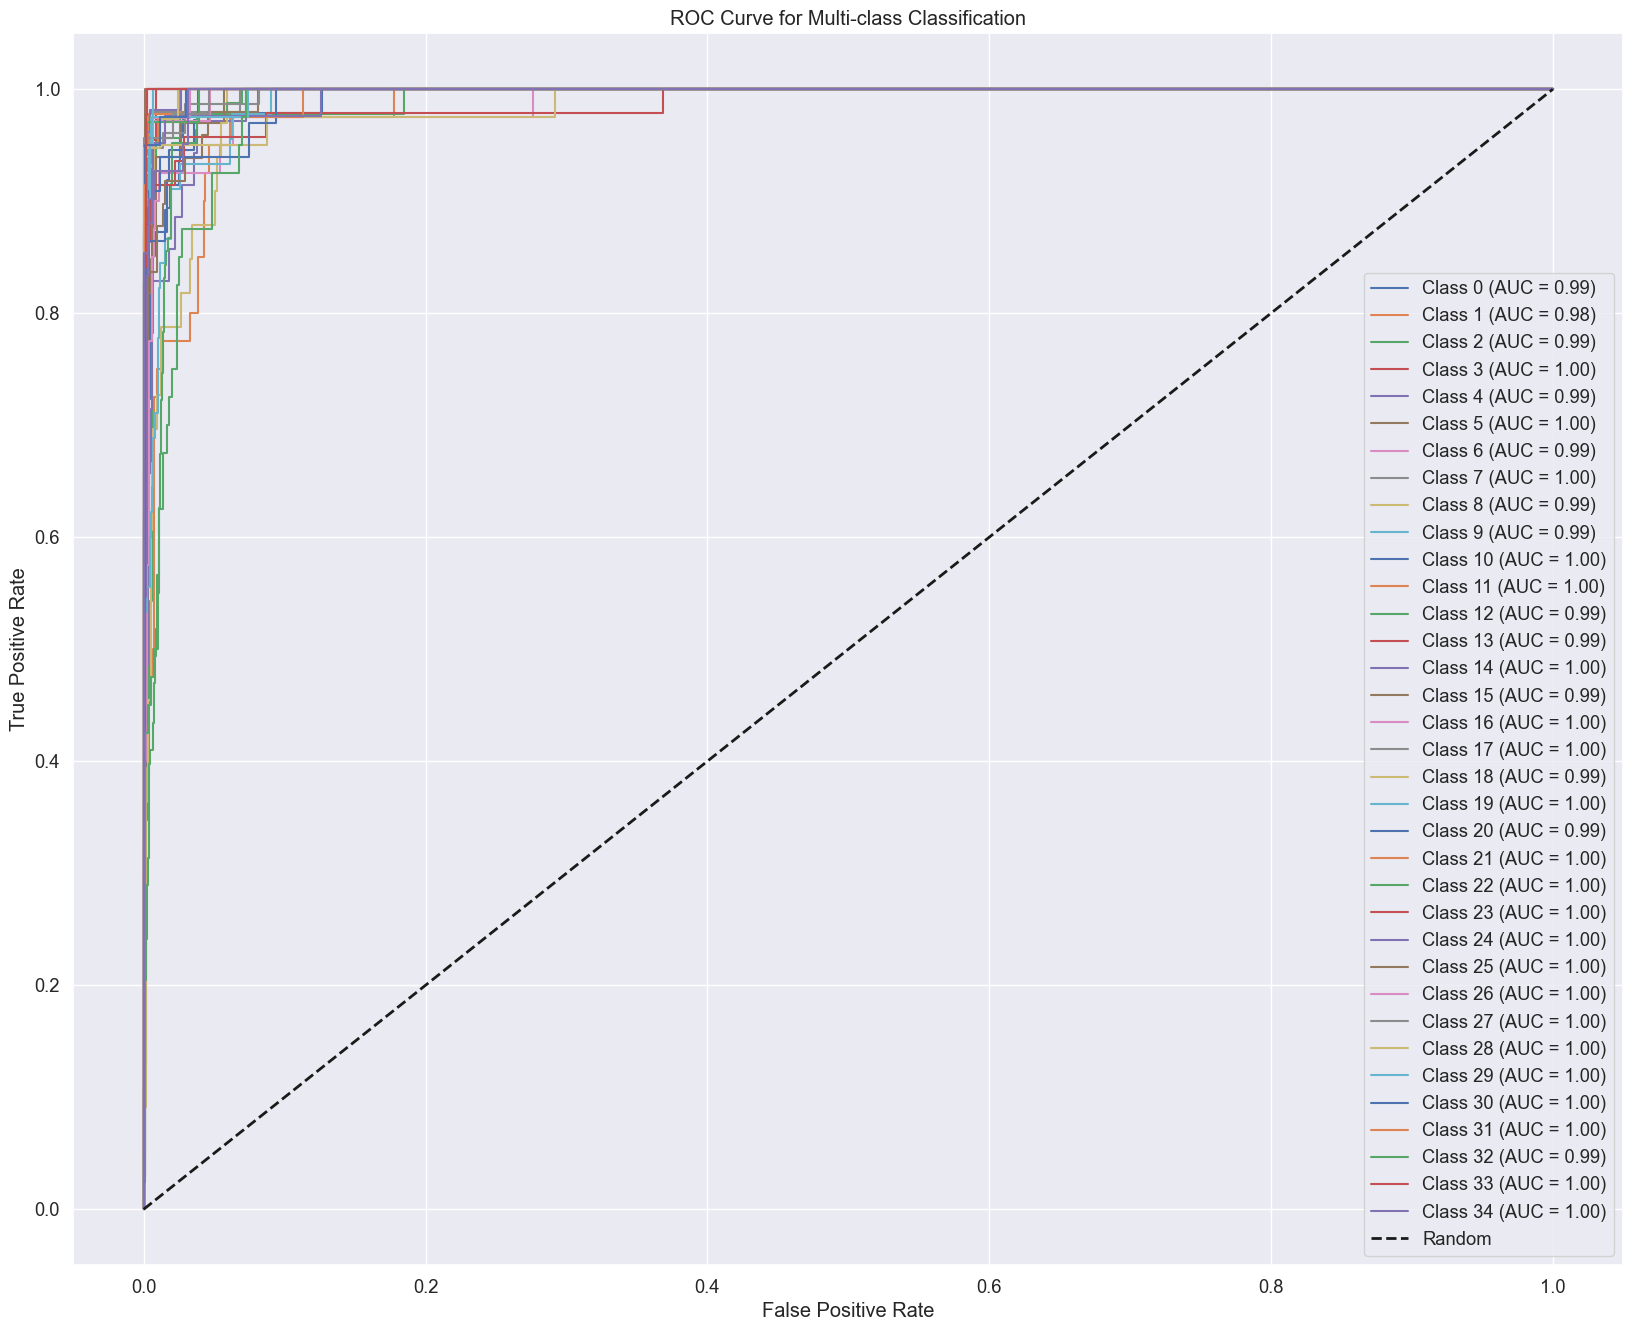

In [61]:
true_labels = inception3b_labels_val
predicted_scores = svm_model.decision_function(val_features_flat)

n_classes = len(train_dataset.dataset.classes)

true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
roc_auc_macro = roc_auc_score(true_labels_bin, predicted_scores, average='macro')
print(f'Macro-average ROC AUC: {roc_auc_macro:.2f}')

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(20, 16))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the saved datasets
train_dataset = torch.load('train_dataset.pth')
val_dataset = torch.load('val_dataset.pth')

# Create DataLoader for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [26]:
# Load pre-trained MobileNetV2 model
mobilenet = models.mobilenet_v2(pretrained=True)

# Remove the fully connected layers from the model
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])

# Define the SVM model
class MobileNetV2Features(nn.Module):
    def __init__(self):
        super(MobileNetV2Features, self).__init__()
        self.mobilenet = mobilenet

    def forward(self, x):
        return self.mobilenet(x)

# Create instances of MobileNetV2Features
model_avgpool = MobileNetV2Features()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\alast/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [28]:
def extract_features_labels(model, loader):
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            outputs = model(images)
            features.append(outputs.squeeze().cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

# Extract features from AvgPool
avgpool_features_train, avgpool_labels_train = extract_features_labels(model_avgpool, train_loader)
avgpool_features_val, avgpool_labels_val = extract_features_labels(model_avgpool, val_loader)

# Extract features from Conv1
conv1 = nn.Sequential(*list(mobilenet.children())[:1])
model_conv1 = MobileNetV2Features()
model_conv1.mobilenet[0] = conv1
conv1_features_train, conv1_labels_train = extract_features_labels(model_conv1, train_loader)
conv1_features_val, conv1_labels_val = extract_features_labels(model_conv1, val_loader)

# Extract features from a middle layer (you can replace "blocks[4][0].conv2" with any other layer you want to use)
middle_layer = nn.Sequential(*list(mobilenet.children())[:-1])
model_middle_layer = MobileNetV2Features()
model_middle_layer.mobilenet = middle_layer
middle_layer_features_train, middle_layer_labels_train = extract_features_labels(model_middle_layer, train_loader)
middle_layer_features_val, middle_layer_labels_val = extract_features_labels(model_middle_layer, val_loader)

In [29]:
# Save the extracted features and labels to .npy files
np.save('mobile_features_train.npy', conv1_features_train)
np.save('mobile_labels_train.npy', conv1_labels_train)
np.save('mobile_features_val.npy', conv1_features_val)
np.save('mobile_labels_val.npy', conv1_labels_val)

np.save('mobile_middle_features_train.npy', middle_layer_features_train)
np.save('mobile_middle_labels_train.npy', middle_layer_labels_train)
np.save('mobile_middle_features_val.npy', middle_layer_features_val)
np.save('mobile_middle_labels_val.npy', middle_layer_labels_val)

np.save('mobile_avgpool_features_train.npy', avgpool_features_train)
np.save('mobile_avgpool_labels_train.npy', avgpool_labels_train)
np.save('mobile_avgpool_features_val.npy', avgpool_features_val)
np.save('mobile_avgpool_labels_val.npy', avgpool_labels_val)

In [3]:
avgpool_features_train = np.load('./mobile-net/mobile_avgpool_features_train.npy')
avgpool_labels_train = np.load('./mobile-net/mobile_avgpool_labels_train.npy')
avgpool_features_val = np.load('./mobile-net/mobile_avgpool_features_val.npy')
avgpool_labels_val = np.load('./mobile-net/mobile_avgpool_labels_val.npy')

conv1_features_train = np.load('./mobile-net/mobile_features_train.npy')
conv1_labels_train = np.load('./mobile-net/mobile_labels_train.npy')
conv1_features_val = np.load('./mobile-net/mobile_features_val.npy')
conv1_labels_val = np.load('./mobile-net/mobile_labels_val.npy')

middle_layer_features_train = np.load('./mobile-net/mobile_middle_features_train.npy')
middle_layer_labels_train = np.load('./mobile-net/mobile_middle_labels_train.npy')
middle_layer_features_val = np.load('./mobile-net/mobile_middle_features_val.npy')
middle_layer_labels_val = np.load('./mobile-net/mobile_middle_labels_val.npy')

In [12]:
middle_layer_features_train.shape

(5912, 3, 224, 224)

In [6]:
# Resize or transform the features to the target size
# avgpool_features_train_resized = resize_features(avgpool_features_train, target_size)
# conv1_features_train_resized = resize_features(conv1_features_train, target_size)
# middle_layer_features_train_resized = resize_features(middle_layer_features_train, target_size)

# avgpool_features_val_resized = resize_features(avgpool_features_val, target_size)
# conv1_features_val_resized = resize_features(conv1_features_val, target_size)
# middle_layer_features_val_resized = resize_features(middle_layer_features_val, target_size)

# Concatenate features from different layers
train_features = np.concatenate([avgpool_features_train, conv1_features_train, middle_layer_features_train], axis=1)
val_features = np.concatenate([avgpool_features_val, conv1_features_val, middle_layer_features_val], axis=1)


# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train an SVM with RBF kernel
svm_model = SVC(kernel='rbf', max_iter=10)
svm_model.fit(train_features_flat, avgpool_labels_train)  # You can choose any set of labels, e.g., avgpool_labels_train or conv1_labels_train

# Evaluate the model on the validation set
predictions = svm_model.predict(val_features_flat)
accuracy = accuracy_score(avgpool_labels_val, predictions)  # You can choose any set of labels, e.g., avgpool_labels_val or conv1_labels_val
print(f"Validation Accuracy: {accuracy}")


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 2 has size 224